In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [5]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNEL=3

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/seminar/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1944 files belonging to 3 classes.


In [7]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

61

In [9]:
for image_batch , label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())


(32, 256, 256, 3)
[0 0 1 1 0 0 0 0 2 0 1 0 2 0 2 1 1 1 2 0 0 1 1 1 1 0 2 1 0 1 0 1]


In [10]:
for image_batch , label_batch in dataset.take(1):
  print(image_batch[0].numpy()) #convert it to numpy as it is tensor


[[[123. 120. 131.]
  [130. 127. 138.]
  [126. 123. 134.]
  ...
  [160. 162. 174.]
  [161. 163. 175.]
  [153. 155. 167.]]

 [[101.  98. 109.]
  [111. 108. 119.]
  [143. 140. 151.]
  ...
  [150. 152. 164.]
  [155. 157. 169.]
  [152. 154. 166.]]

 [[114. 111. 122.]
  [121. 118. 129.]
  [106. 103. 114.]
  ...
  [152. 154. 167.]
  [161. 163. 176.]
  [162. 164. 177.]]

 ...

 [[115. 111. 125.]
  [112. 108. 122.]
  [110. 106. 120.]
  ...
  [144. 142. 156.]
  [143. 141. 155.]
  [170. 168. 182.]]

 [[122. 118. 132.]
  [117. 113. 127.]
  [113. 109. 123.]
  ...
  [133. 131. 145.]
  [153. 151. 165.]
  [173. 171. 185.]]

 [[133. 129. 143.]
  [127. 123. 137.]
  [120. 116. 130.]
  ...
  [118. 116. 130.]
  [146. 144. 158.]
  [157. 155. 169.]]]


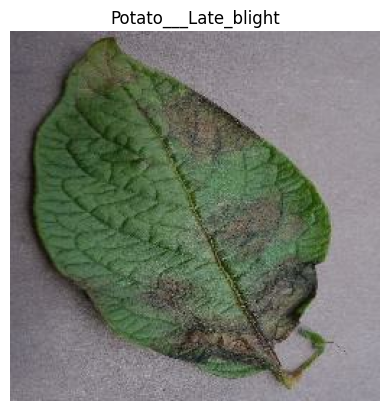

In [11]:
for image_batch , label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype('uint8'))
  plt.title(class_names[label_batch[0]])
  plt.axis('off')

<ipython-input-12-8aa450a42303>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,4,i+1)


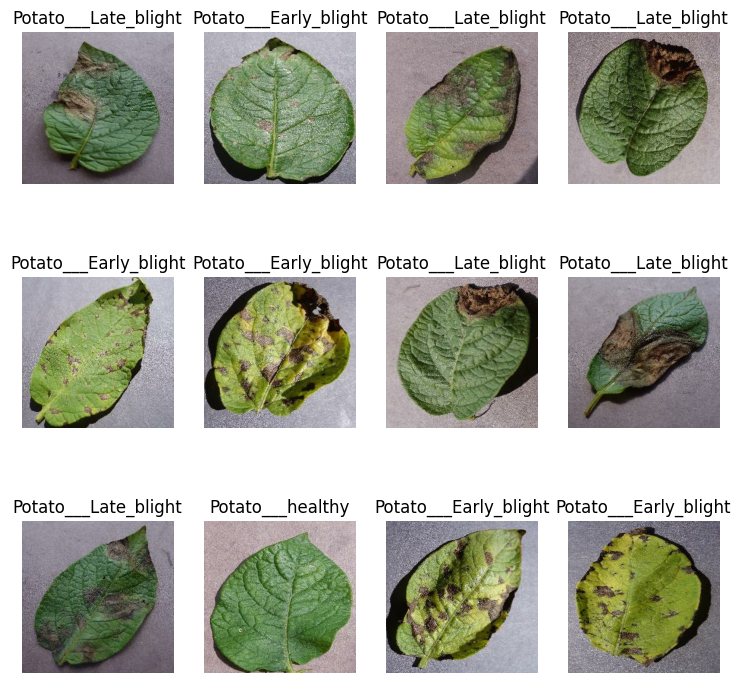

In [12]:
plt.subplots(figsize=(9, 9))
for image_batch , label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [13]:
def get_data_partition(ds , train_split=0.8 , val_split=0.1 , test_split=0.1,shuffle=True , shuffle_size=10000):

  ds_size=len(ds)

  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)
  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)

  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)



  return train_ds , val_ds , test_ds

In [14]:
train_ds , val_ds , test_ds=get_data_partition(dataset)

In [15]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255) #here 1.0 shows ivision operation is performed as a floating-point division rather than integer division

])

In [17]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.3)
])

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model pre-trained on ImageNet, excluding the top layer
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the convolutional base layers to retain learned features
vgg16_base.trainable = False

# Add new fully-connected layers for plant disease classification
x = vgg16_base.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Create the final model with the pre-trained base and new layers
model = Model(inputs=vgg16_base.input, outputs=predictions)

# Compile the model for training on your PlantVillage dataset
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model using your defined training and validation data (train_ds, val_ds)
history2 = model.fit(train_ds,
                    epochs=20,  # Adjust the number of epochs as needed
                    batch_size=32,
                    validation_data=val_ds)

# Evaluate the model's performance on your test data (test_ds)
scores = model.evaluate(test_ds)
print("Test accuracy:", scores[1])

# # Save the trained model (optional)
# model_version = 1
# model.save(f"plant_disease_classifier_{model_version}.h5")


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
48/48 [==============================] - 300s 428ms/step - loss: 4.9552 - accuracy: 0.8298 - val_loss: 0.2011 - val_accuracy: 0.9792
Epoch 2/20
48/48 [==============================] - 9s 189ms/step - loss: 0.5551 - accuracy: 0.9535 - val_loss: 0.0703 - val_accuracy: 0.9844
Epoch 3/20
48/48 [==============================] - 9s 193ms/step - loss: 0.2535 - accuracy: 0.9791 - val_loss: 0.2099 - val_accuracy: 0.9844
Epoch 4/20
48/48 [==============================] - 10s 202ms/step - loss: 0.2481 - accuracy: 0.9764 - val_loss: 3.1945e-04 - val_accuracy: 1.0000
Epoch 5/20
48/48 [==============================] - 9s 197ms/step - loss: 0.0757 - accuracy: 0.9915 - val_loss: 9.7862e-05 - val_accuracy: 1.0000
Epoch 6/20
48/48 [==============================] - 9s 194ms/step - loss: 0.0813 - accuracy: 0.9921 - val_loss: 0.0550 - val_accuracy: 0.9948
Epoch 7/20
48/48 [==============================] - 9s 192ms/step - loss

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
model1 = keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model1.build(input_shape=input_shape)

model1.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train the first model
history1 = model1.fit(
    train_ds,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
48/48 [==============================] - 11s 109ms/step - loss: 0.8557 - accuracy: 0.5746 - val_loss: 1.1042 - val_accuracy: 0.6615
Epoch 2/20
48/48 [==============================] - 3s 60ms/step - loss: 0.4726 - accuracy: 0.8030 - val_loss: 0.4757 - val_accuracy: 0.8438
Epoch 3/20
48/48 [==============================] - 3s 60ms/step - loss: 0.2737 - accuracy: 0.8946 - val_loss: 0.3262 - val_accuracy: 0.9167
Epoch 4/20
48/48 [==============================] - 3s 63ms/step - loss: 0.2168 - accuracy: 0.9103 - val_loss: 0.2695 - val_accuracy: 0.9479
Epoch 5/20
48/48 [==============================] - 3s 62ms/step - loss: 0.1747 - accuracy: 0.9326 - val_loss: 0.2345 - val_accuracy: 0.9323
Epoch 6/20
48/48 [==============================] - 3s 61ms/step - loss: 0.1801 - accuracy: 0.9306 - val_loss: 0.1975 - val_accuracy: 0.9271
Epoch 7/20
48/48 [==============================] - 3s 61ms/step - loss: 0.1391 - accuracy: 0.9503 - val_loss: 0.2709 - val_accuracy: 0.8698
Epoch 8/20


In [20]:
# Define and train the second model (VGG16-based)
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
vgg16_base.trainable = False

x = vgg16_base.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model2 = Model(inputs=vgg16_base.input, outputs=predictions)

model2.compile(optimizer=Adam(learning_rate=0.0001),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

history2 = model2.fit(train_ds,
                      epochs=20,
                      batch_size=32,
                      validation_data=val_ds)

Epoch 1/20
48/48 [==============================] - 10s 195ms/step - loss: 3.2379 - accuracy: 0.8416 - val_loss: 0.0544 - val_accuracy: 0.9896
Epoch 2/20
48/48 [==============================] - 9s 194ms/step - loss: 0.4775 - accuracy: 0.9601 - val_loss: 0.1209 - val_accuracy: 0.9896
Epoch 3/20
48/48 [==============================] - 9s 196ms/step - loss: 0.3765 - accuracy: 0.9745 - val_loss: 1.6490e-04 - val_accuracy: 1.0000
Epoch 4/20
48/48 [==============================] - 9s 195ms/step - loss: 0.2120 - accuracy: 0.9843 - val_loss: 0.0547 - val_accuracy: 0.9948
Epoch 5/20
48/48 [==============================] - 9s 193ms/step - loss: 0.2202 - accuracy: 0.9804 - val_loss: 0.1231 - val_accuracy: 0.9948
Epoch 6/20
48/48 [==============================] - 9s 191ms/step - loss: 0.1312 - accuracy: 0.9908 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 7/20
48/48 [==============================] - 9s 191ms/step - loss: 0.0606 - accuracy: 0.9928 - val_loss: 2.1855e-07 - val_accuracy: 1.00

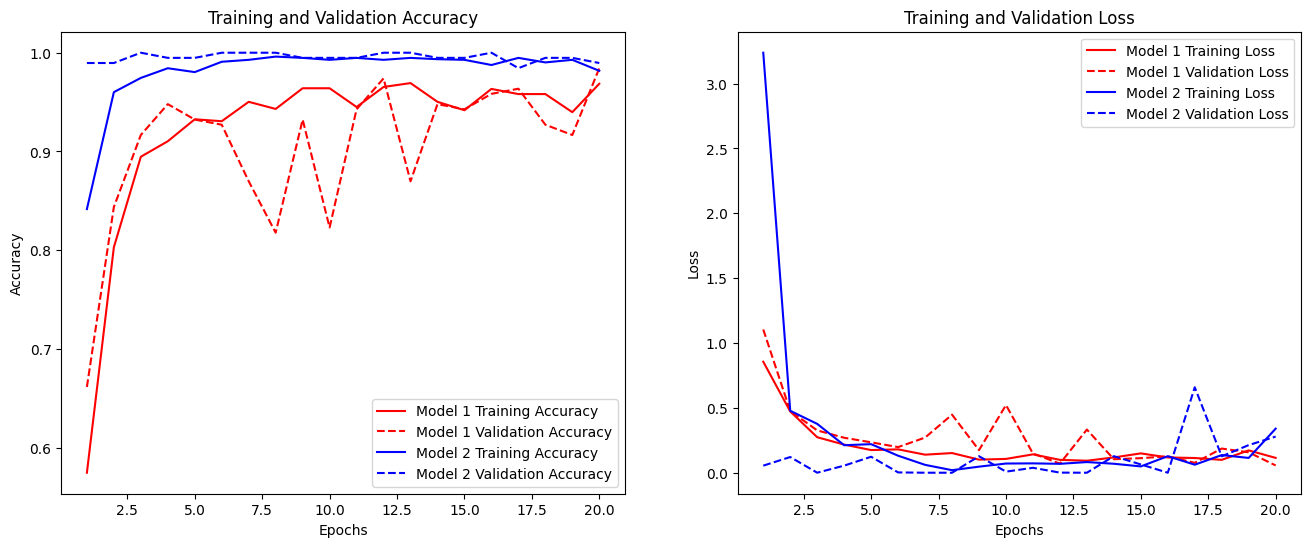

In [21]:
# Plotting Accuracy and Loss for both models
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs = range(1, 21)  # assuming 20 epochs were trained for both models

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc1, 'r', label='Model 1 Training Accuracy')
plt.plot(epochs, val_acc1, 'r--', label='Model 1 Validation Accuracy')
plt.plot(epochs, acc2, 'b', label='Model 2 Training Accuracy')
plt.plot(epochs, val_acc2, 'b--', label='Model 2 Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss1, 'r', label='Model 1 Training Loss')
plt.plot(epochs, val_loss1, 'r--', label='Model 1 Validation Loss')
plt.plot(epochs, loss2, 'b', label='Model 2 Training Loss')
plt.plot(epochs, val_loss2, 'b--', label='Model 2 Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()